# High Frequency Pairs Trading

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.options.display.max_columns = 99

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#===============================
#     Choose stock pairs
#===============================

def test_stationarity(stocks):
    new_stocks_symbol=[]
    for key,value in stocks.items():
        test = adfuller(stocks[key]['Adj Close'].iloc[start_training:end_training+1],
                        regression='ct') 
        if test[1]>0.05:
            print(key,'is non-stationary')
            new_stocks_symbol.append(key)
        else:
            print(key,'is stationary')  
    return new_stocks_symbol

def coint_test(y, x):
    t_test, p_value, _ = coint(y, x)
    l=[]
    l.append(t_test)
    l.append(p_value)
    return l

def hedge_ratio(y, x):
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    return model.params[0],model.params[1]

def get_z_score_func(hedge, spreads):
    if spreads.std()==0:
        return lambda p1, p2: 0
    return lambda p1, p2: (p1-hedge*p2-spreads.mean())/spreads.std()

def target_pct(y_shares, x_shares, y_price, x_price):
    y_dollars = y_shares * y_price
    x_dollars = x_shares * x_price
    y_target_pct = float(float(y_dollars) / float((abs(y_dollars) + abs(x_dollars))))
    x_target_pct = float(float(x_dollars) / float((abs(y_dollars) + abs(x_dollars))))
    return (y_target_pct, x_target_pct)

def choose_pairs(pairs,start,end):
    global portfolio
    global position
    
    num_of_trades=0
    position=0
    pair_info={}
    selected_pair_info={}
    selected_pairs=[]
    for pair in pairs:
        s1,s2=pair
        y = stocks[s1]['Adj Close'].iloc[start:end+1]
        x = stocks[s2]['Adj Close'].iloc[start:end+1]
        corr=x.corr(y)
        if corr>=corr_threshold:
            coint_result=coint_test(y, x)
            t_test=coint_result[0]
            p_value=coint_result[1]
            if t_test<=t_test_threshold:
                mean,hedge = hedge_ratio(y, x)
                spreads = y - hedge*x
                pair_info[pair] = {
                    'correlation':corr,
                    'p_value': p_value,
                    't_test': t_test,
                    'mean':mean,
                    'hedge':hedge,
                    'spreads':spreads
                }        

    pairs2 = []
    for pair, value in pair_info.items():
        pairs2.append((pair,value['t_test']))
    pairs2.sort(key=lambda x: x[1])
    
    if len(pairs2)>=number_of_pairs:
        for i in range(0,number_of_pairs):
            selected_pairs.append(pairs2[i][0])
            a,b= pairs2[i]
            print('Selected pairs: ', a, ' t_test: ', b,' corr: ',
                  pair_info[pairs2[i][0]]['correlation'])
            selected_pair_info[pairs2[i][0]]= {
                'correlation':pair_info[pairs2[i][0]]['correlation'],
                'p_value': pair_info[pairs2[i][0]]['p_value'],
                't_test': pair_info[pairs2[i][0]]['t_test'],
                'mean': pair_info[pairs2[i][0]]['mean'],
                'hedge': pair_info[pairs2[i][0]]['hedge'],
                'spreads': pair_info[pairs2[i][0]]['spreads']
            }
    else:
        for i in range(0,len(pairs2)):
            selected_pairs.append(pairs2[i][0])
            a,b= pairs2[i]
            print('Selected pairs: ', a, ' t_test: ', b,' corr: ',
                  pair_info[pairs2[i][0]]['correlation'])
            selected_pair_info[pairs2[i][0]]= {
                'correlation':pair_info[pairs2[i][0]]['correlation'],
                'p_value': pair_info[pairs2[i][0]]['p_value'],
                't_test': pair_info[pairs2[i][0]]['t_test'],
                'mean': pair_info[pairs2[i][0]]['mean'],
                'hedge': pair_info[pairs2[i][0]]['hedge'],
                'spreads': pair_info[pairs2[i][0]]['spreads']
            }
        
    for each in selected_pairs:
        portfolio[(each,each[0])]={'# of shares':0,'transaction':0,'record':0}
        portfolio[(each,each[1])]={'# of shares':0,'transaction':0,'record':0}
        temp_record[(each[0],each[1])]=[0,0]
        
    return pair_info,selected_pair_info,selected_pairs


In [3]:
#================================
# Call check_pairs() every minute
#================================

def check_pairs(selected_pair_info, selected_pairs,k):
    global portfolio
    global position
    if position<number_of_pairs:
        check_pairs_for_entry(selected_pair_info, selected_pairs, k)
    if position>0: 
        check_pairs_for_exit(selected_pair_info, selected_pairs, k)
        
        
def check_pairs_for_entry(selected_pair_info, selected_pairs,k):
    global portfolio
    global position
    global stocks
    global pairs_symbol_traded
    pairs = []
    for pair, pair_info in selected_pair_info.items():
        y=stocks[pair[0]].iloc[start_test:end_test+1]['Adj Close'].iloc[k]
        x=stocks[pair[1]].iloc[start_test:end_test+1]['Adj Close'].iloc[k]

        z_score_func=get_z_score_func(pair_info['hedge'],pair_info['spreads'])
        z_score = z_score_func(y, x)
        hedge = pair_info['hedge']
        t_test=pair_info['t_test']
        target1, target2 = target_pct(1, hedge, y, x)

        s1, s2 = pair
        if portfolio[(pair,s1)]['# of shares']==0 and portfolio[(pair,s2)]['# of shares']==0 and z_score > entry_threshold and z_score < stop_loss_threshold:
            if pair in pairs_symbol_traded:
                if capital[pair]>0:
                    # short top, long bottom
                    pairs.append((s1, s2, z_score, -target1, target2, y, x, hedge))
                    pairs_symbol_traded.append(pair)
            else:
                # short top, long bottom
                pairs.append((s1, s2, z_score, -target1, target2, y, x, hedge))
                pairs_symbol_traded.append(pair)
                
        elif portfolio[(pair,s1)]['# of shares']==0 and portfolio[(pair,s2)]['# of shares']==0 and z_score < -entry_threshold and z_score > -stop_loss_threshold:
            if pair in pairs_symbol_traded:
                if capital[pair]>0:
                    # long top, short bottom
                    pairs.append((s1, s2, z_score, target1, -target2, y, x, hedge))
                    pairs_symbol_traded.append(pair)
            else:
                # long top, short bottom
                pairs.append((s1, s2, z_score, target1, -target2, y, x, hedge))
                pairs_symbol_traded.append(pair)
            
 
    if len(pairs)>0:
        for i in range(0,len(pairs)):
            s1, s2, z_score, target1, target2, y, x, hedge = pairs[i]
            pair_check=(s1,s2)
            print('Enter: ', s1, s2, z_score, target1, target2, y, x, hedge)

            n=0
            for pair_symbol in pairs_symbol_traded:
                if pair_check == pair_symbol:
                    n+=1
            if n==1:
                order_target_percent(s1, s2, target1, target2, y, x, initial_capital/number_of_pairs)
            else:
                order_target_percent(s1, s2, target1, target2, y, x, capital[pair_check])
            
        position=position+len(pairs)
             
        
def check_pairs_for_exit(selected_pair_info, selected_pairs, k):
    global portfolio
    global position
    for pair in selected_pairs:
        s1, s2 = pair
        pos1 = portfolio[(pair,s1)]['# of shares']
        pos2 = portfolio[(pair,s2)]['# of shares']
        
        if pos1==0 and pos2==0:
            continue
        
        pair_info = selected_pair_info[pair]
            
        y=stocks[pair[0]].iloc[start_test:end_test+1]['Adj Close'].iloc[k]
        x=stocks[pair[1]].iloc[start_test:end_test+1]['Adj Close'].iloc[k]
        
        z_score_func=get_z_score_func(pair_info['hedge'],pair_info['spreads'])
        z_score = z_score_func(y, x)
        hedge = pair_info['hedge']

        s1, s2 = pair
        if pos1<0 and pos2>0:
            if z_score < exit_threshold or z_score > stop_loss_threshold:
                print('Close position by buying ', s1, s2, z_score, pos1, pos2, y, x, hedge)
                order_target_percent(s1, s2, 0, 0, y, x, 0)
                position=position-1
        elif pos1>0 and pos2<0:
            if z_score > -exit_threshold or z_score < -stop_loss_threshold: 
                print('Close position by selling ', s1, s2, z_score, pos1, pos2, y, x, hedge)
                order_target_percent(s1, s2, 0, 0, y, x, 0)
                position=position-1

                         
def order_target_percent(s1, s2, target1, target2, p1, p2, account_capital):
    global initial_capital
    global portfolio
    global transaction_record
    global num_of_trades
    global temp_record
    global winning
    global lose
    global capital
    transaction_record=transaction_record+1
    
    temp_pair=(s1,s2)
    
    if target1>0 and target2<0 or target1<0 and target2>0:
        num_of_trades+=1
        temp_record[(s1,s2)]=[0,0]
        
        portfolio[((s1,s2),s1)]={'amount of money': (2*account_capital)*target1,
                     '# of shares':float(float((2*account_capital)*target1)/float(p1)),
                     'price_open':p1,
                      'transaction': 1,
                      'record':(2*account_capital)*target1/p1}    
        portfolio[((s1,s2),s2)]={'amount of money': (2*account_capital)*target2,
                     '# of shares':float(float((2*account_capital)*target2)/float(p2)),
                     'price_open':p2,
                      'transaction': 1,
                      'record':(2*account_capital)*target2/p2}
        
        print('s1 # of shares'+str(portfolio[((s1,s2),s1)]['# of shares']))
        print('s2 # of shares'+str(portfolio[((s1,s2),s2)]['# of shares']))
        
        
        temp_record[(s1,s2)][0]=portfolio[((s1,s2),s1)]['# of shares']*p1+portfolio[((s1,s2),s2)]['# of shares']*p2
      
    
    elif target1==0 and target2==0:
        
        capital[temp_pair]=initial_capital/number_of_pairs+p1*portfolio[((s1,s2),s1)]['# of shares']+p2*portfolio[((s1,s2),s2)]['# of shares']-portfolio[((s1,s2),s1)]['price_open']*portfolio[((s1,s2),s1)]['# of shares']-portfolio[((s1,s2),s2)]['price_open']*portfolio[((s1,s2),s2)]['# of shares']
        
        portfolio[((s1,s2),s1)]['amount of money']=0
        portfolio[((s1,s2),s1)]['# of shares']=0
        portfolio[((s1,s2),s1)]['transaction']=1
        
        portfolio[((s1,s2),s2)]['amount of money']=0
        portfolio[((s1,s2),s2)]['# of shares']=0
        portfolio[((s1,s2),s2)]['transaction']=1
        
        temp_record[(s1,s2)][1]=portfolio[((s1,s2),s1)]['# of shares']*p1+portfolio[((s1,s2),s2)]['# of shares']*p2
        count_winning_and_loss(s1,s2)
        print('account value'+str(capital[temp_pair]))
           
        
def count_winning_and_loss(s1,s2):
    global temp_record
    global winning
    global loss
    if temp_record[(s1,s2)][0]==temp_record[(s1,s2)][1]:
        print('error......')
    if temp_record[(s1,s2)][0]<temp_record[(s1,s2)][1]:
        print(s1,s2,' win')
        winning+=1
    if temp_record[(s1,s2)][0]>temp_record[(s1,s2)][1]:
        print(s1,s2,' lose')
        loss+=1
    
        
def record(i,num,selected_pairs):
    global dfpnl
    global portfolio 
    global transaction_record 
    
    # record pnl for each pair 
    for pair in selected_pairs:
        s1, s2 = pair
        pos1 = portfolio[(pair,s1)]['# of shares']
        pos2 = portfolio[(pair,s2)]['# of shares']
        if pos1==0 and pos2==0:
            continue
        temp=pos1*(stocks[s1].iloc[start_test:end_test+1]['Adj Close'].iloc[i+1]-stocks[s1].iloc[start_test:end_test+1]['Adj Close'].iloc[i])+pos2*(stocks[s2].iloc[start_test:end_test+1]['Adj Close'].iloc[i+1]-stocks[s2].iloc[start_test:end_test+1]['Adj Close'].iloc[i])
        dfpnl[num][pair[0]+', '+pair[1]+' pnl'][i+1]=temp 
        
    # record cumulative pnl for each pair 
    for pair in selected_pairs:
        dfpnl[num][pair[0]+', '+pair[1]+' cumulative pnl']=dfpnl[num][pair[0]+', '+pair[1]+' pnl'].cumsum()
            
            
    # pnl
    change=0
    for each, value in portfolio.items():
        change=change+value['# of shares']*(stocks[each[1]].iloc[start_test:end_test+1]['Adj Close'].iloc[i+1]-stocks[each[1]].iloc[start_test:end_test+1]['Adj Close'].iloc[i])-value['transaction']*abs(value['record'])*transaction_cost_per_share
        value['transaction']=0 
    dfpnl[num]['PnL'][i+1]=change-transaction_record*2*transaction_cost 
    transaction_record=0 
    
    
    # cumulative pnl
    dfpnl[num]['Cumulative PnL']=dfpnl[num]['PnL'].cumsum()
    
    # value
    
    dfpnl[num]['value']=dfpnl[num]['Cumulative PnL']+initial_capital
    
    # return
    dfpnl[num]['return']=dfpnl[num]['Cumulative PnL']/initial_capital

    
  

In [4]:
#================
# Read csv files
#================

df=pd.read_csv("test.csv") #S&P500_Intraday
stocks={}


In [5]:
#============================
# Please choose frequency
#============================

freq=10

lst = [i for i in range(0,len(df),freq)]
df2=df.iloc[lst]
for i in range(0,len(df2.columns),3):
    stocks[df2.columns[i]]=df2.iloc[:,[i,i+1]].set_index(df2.columns[i])
    stocks[df2.columns[i]].index.names=['Time']
    stocks[df2.columns[i]].columns=['Adj Close']


In [6]:
#====================================
# Feel free to change the parameters
#====================================
corr_threshold=0.9
t_test_threshold=-3.34
number_of_pairs=1

entry_threshold=2.5
gap=0.5
exit_threshold =entry_threshold-gap
stop_loss_threshold=5
transaction_cost=0 #fixed
transaction_cost_per_share=0 # per share

number=1 # modify


#============================
#       do not change
#============================
initial_capital=1000000
transaction_record=0 
portfolio={}
dfpnl={}
trainning_interval=int(19500/freq)
interval=int(9750/freq)

pairs_symbol_traded=[]
capital={}

length=len(stocks['A UN Equity'])

num_of_trades=0
trade_record={}
temp_record={} # for compute winnging and loss trades
winning=0
lose=0

start_training=0
end_training=trainning_interval-1

start_test=0
end_test=0

store_selected_pairs={}
store_selected_pair_info={}

#============================================
#                   START!
#============================================
for i in range(number):
    pairs_symbol_traded.clear()
    num_of_trades=0
    winning=0
    loss=0
    if trainning_interval+interval*i<length:
        start_training+=i*interval
        end_training+=i*interval
        
        #-------------------
        # Stationarity test 
        #-------------------
        symbol=test_stationarity(stocks)
        
        #-------------------
        # Pair permutation
        #-------------------
        pairs = []
        for c in range(len(symbol)-1):
            for j in range(c+1,len(symbol)):
                pairs.append((symbol[c],symbol[j]))
              
        #---------------------------------------     
        # Create dfpnl to store testing results
        #---------------------------------------
        start_test=end_training+1 # start date of test
        end_test=start_test+interval-1 # end date of test
        dfpnl[i]=pd.DataFrame(columns=['value','PnL','Cumulative PnL'],
                              index=stocks['A UN Equity'].index).iloc[start_test:end_test+1]
   
        
             
        #--------------
        #     MAIN
        #--------------
        # Choose pairs
        #--------------
        d_pair_info,d_selected_pair_info,l_selected_pairs=choose_pairs(pairs,start_training,end_training)
        store_selected_pairs[i]=l_selected_pairs
        store_selected_pair_info[i]=d_selected_pair_info
        
        for each in l_selected_pairs: # add columns in dfpnl[i] to record pairs' pnl
            dfpnl[i][each[0]+', '+each[1]+' pnl']=None 
            dfpnl[i][each[0]+', '+each[1]+' cumulative pnl']=None 
        
        a=len(stocks['A UN Equity'].iloc[start_test:end_test+1])
        
        #----------------
        # Start trading   
        #----------------
        for b in range(0,a-1):
            print('Date: ',dfpnl[i].index[b])
            check_pairs(d_selected_pair_info, l_selected_pairs,b)
            record(b,i,l_selected_pairs)
            
        #-----------------------------------------------
        # Close all positions at the end of test period
        #-----------------------------------------------
        for pair in l_selected_pairs:
            s1, s2 = pair
            pos1 = portfolio[(pair,s1)]['# of shares']
            pos2 = portfolio[(pair,s2)]['# of shares']
            if pos1==0 and pos2==0:
                continue
            print('Close position by selling ',s1, s2, 0, pos1, pos2, 0, 0, 0)
            order_target_percent(s1, s2, 0, 0, stocks[s1].iloc[start_test:end_test+1]['Adj Close'][-1],stocks[s2].iloc[start_test:end_test+1]['Adj Close'][-1],0)
            position=position-1
       
        #----------------------------------------------
        # Record the number of winning and loss trades
        #----------------------------------------------
        trade_record[i]={'number of trades:':num_of_trades,
                        'numer of winning trades:':winning,
                        'numer of loss trades:':loss}
        
    #-----------------------------
    # For the last testing period
    #-----------------------------       
    elif trainning_interval+interval*i>length and training_interval+i*interval-length<interval:
        start_training+=i*interval
        end_training+=i*interval
        
        #-------------------
        # Stationarity test 
        #-------------------
        symbol=test_stationarity(stocks)
        
        #------------------
        # Pair permutation
        #------------------
        pairs = []
        for c in range(len(symbol)-1):
            for j in range(c+1,len(symbol)):
                pairs.append((symbol[c],symbol[j]))
                                
        #---------------------------------------   
        # Create dfpnl to store testing results
        #---------------------------------------
        start_test=end_training+1 # start date of test
        end_test=length-1 # end date of test
        dfpnl[i]=pd.DataFrame(columns=['value','PnL','Cumulative PnL'],index=stocks['A UN Equity'].index).iloc[start_test:end_test+1]
        
        #--------------
        #     MAIN
        #--------------
        # Choose pairs
        #--------------
        d_pair_info,d_selected_pair_info,l_selected_pairs=choose_pairs(pairs,start_training,end_training)
        store_selected_pairs[i]=l_selected_pairs
        store_selected_pair_info[i]=d_selected_pair_info
        
        for each in l_selected_pairs: # add columns in dfpnl[i] to record pairs' pnl
            dfpnl[i][each[0]+', '+each[1]+' pnl']=None 
            dfpnl[i][each[0]+', '+each[1]+' cumulative pnl']=None 
            
        a=len(stocks['A UN Equity'].iloc[start_test:end_test+1])
        
        #---------------
        # Start trading   
        #---------------
        for b in range(0,a-1):
            print('Date: ',dfpnl[i].index[b])
            check_pairs(d_selected_pair_info, l_selected_pairs,b)
            record(b,i,l_selected_pairs)
                   
        #-----------------------------------------------
        # Close all positions at the end of test period
        #-----------------------------------------------
        for pair in l_selected_pairs:
            s1, s2 = pair
            pos1 = portfolio[(pair,s1)]['# of shares']
            pos2 = portfolio[(pair,s2)]['# of shares']
            if pos1==0 and pos2==0:
                continue
            print('Close position by selling ',s1, s2, 0, pos1, pos2, 0, 0, 0)
            order_target_percent(s1, s2, 0, 0, stocks[s1].iloc[start_test:end_test+1]['Adj Close'][-1],stocks[s2].iloc[start_test:end_test+1]['Adj Close'][-1],0)
            position=position-1
  
        #----------------------------------------------
        # Record the number of winning and loss trades
        #----------------------------------------------
        trade_record[i]={'number of trades:':num_of_trades,
                        'numer of winning trades:':winning,
                        'numer of loss trades:':loss}
        


A UN Equity is non-stationary
AAL UW Equity is non-stationary
AAP UN Equity is non-stationary
AAPL UW Equity is non-stationary
ABBV UN Equity is non-stationary
ABC UN Equity is non-stationary
ABT UN Equity is non-stationary
ACN UN Equity is non-stationary
ADBE UW Equity is non-stationary
ADI UW Equity is stationary
ADM UN Equity is non-stationary
ADP UW Equity is non-stationary
ADS UN Equity is non-stationary
ADSK UW Equity is non-stationary
AEE UN Equity is non-stationary
AEP UN Equity is non-stationary
AES UN Equity is non-stationary
AET UN Equity is non-stationary
AFL UN Equity is non-stationary
AGN UN Equity is non-stationary
AIG UN Equity is non-stationary
AIV UN Equity is non-stationary
AIZ UN Equity is non-stationary
AJG UN Equity is non-stationary
AKAM UW Equity is stationary
ALB UN Equity is non-stationary
ALGN UW Equity is non-stationary
ALK UN Equity is non-stationary
ALL UN Equity is non-stationary
ALLE UN Equity is non-stationary
ALXN UW Equity is non-stationary
AMAT UW Eq

Date:  11/9/17 12:50
Date:  11/9/17 13:00
Date:  11/9/17 13:10
Date:  11/9/17 13:20
Date:  11/9/17 13:30
Date:  11/9/17 13:40
Date:  11/9/17 13:50
Date:  11/9/17 14:00
Date:  11/9/17 14:10
Date:  11/9/17 14:20
Date:  11/9/17 14:30
Date:  11/9/17 14:40
Date:  11/9/17 14:50
Date:  11/9/17 15:00
Date:  11/9/17 15:10
Date:  11/9/17 15:20
Date:  11/9/17 15:30
Date:  11/9/17 15:40
Date:  11/9/17 15:50
Date:  11/10/17 09:30
Date:  11/10/17 09:40
Date:  11/10/17 09:50
Date:  11/10/17 10:00
Date:  11/10/17 10:10
Date:  11/10/17 10:20
Date:  11/10/17 10:30
Date:  11/10/17 10:40
Date:  11/10/17 10:50
Date:  11/10/17 11:00
Date:  11/10/17 11:10
Date:  11/10/17 11:20
Date:  11/10/17 11:30
Date:  11/10/17 11:40
Date:  11/10/17 11:50
Date:  11/10/17 12:00
Date:  11/10/17 12:10
Date:  11/10/17 12:20
Date:  11/10/17 12:30
Date:  11/10/17 12:40
Date:  11/10/17 12:50
Date:  11/10/17 13:00
Date:  11/10/17 13:10
Date:  11/10/17 13:20
Date:  11/10/17 13:30
Date:  11/10/17 13:40
Date:  11/10/17 13:50
Date:  

Date:  11/22/17 12:40
Date:  11/22/17 12:50
Date:  11/22/17 13:00
Date:  11/22/17 13:10
Date:  11/22/17 13:20
Date:  11/22/17 13:30
Date:  11/22/17 13:40
Date:  11/22/17 13:50
Date:  11/22/17 14:00
Date:  11/22/17 14:10
Date:  11/22/17 14:20
Date:  11/22/17 14:30
Date:  11/22/17 14:40
Date:  11/22/17 14:50
Date:  11/22/17 15:00
Date:  11/22/17 15:10
Date:  11/22/17 15:20
Date:  11/22/17 15:30
Date:  11/22/17 15:40
Date:  11/22/17 15:50
Date:  11/23/17 09:30
Date:  11/23/17 09:40
Date:  11/23/17 09:50
Date:  11/23/17 10:00
Date:  11/23/17 10:10
Date:  11/23/17 10:20
Date:  11/23/17 10:30
Date:  11/23/17 10:40
Date:  11/23/17 10:50
Date:  11/23/17 11:00
Date:  11/23/17 11:10
Date:  11/23/17 11:20
Date:  11/23/17 11:30
Date:  11/23/17 11:40
Date:  11/23/17 11:50
Date:  11/23/17 12:00
Date:  11/23/17 12:10
Date:  11/23/17 12:20
Date:  11/23/17 12:30
Date:  11/23/17 12:40
Date:  11/23/17 12:50
Date:  11/23/17 13:00
Date:  11/23/17 13:10
Date:  11/23/17 13:20
Date:  11/23/17 13:30
Date:  11/

# Test results

In [7]:
# the selected pairs
store_selected_pairs[0]

[('ABT UN Equity', 'APH UN Equity')]

In [8]:
# specific information of 10 selected pairs
# for example:
store_selected_pair_info[0][('ABT UN Equity', 'APH UN Equity')]# 'IDXX UW Equity', 'SO UN Equity'

{'correlation': 0.93936441428531325,
 'hedge': 0.70697957674436851,
 'mean': -6.0905159964290654,
 'p_value': 0.024274126716016343,
 'spreads': Time
 8/21/17 09:30    -6.535291
 8/21/17 09:40    -6.590640
 8/21/17 09:50    -6.664780
 8/21/17 10:00    -6.717710
 8/21/17 10:10    -6.737199
 8/21/17 10:20    -6.641640
 8/21/17 10:30    -6.484082
 8/21/17 10:40    -6.487012
 8/21/17 10:50    -6.526501
 8/21/17 11:00    -6.520129
 8/21/17 11:10    -6.597199
 8/21/17 11:20    -6.618757
 8/21/17 11:30    -6.565478
 8/21/17 11:40    -6.624269
 8/21/17 11:50    -6.708757
 8/21/17 12:00    -6.651338
 8/21/17 12:10    -6.515989
 8/21/17 12:20    -6.575478
 8/21/17 12:30    -6.558757
 8/21/17 12:40    -6.560827
 8/21/17 12:50    -6.559618
 8/21/17 13:00    -6.574967
 8/21/17 13:10    -6.560827
 8/21/17 13:20    -6.639106
 8/21/17 13:30    -6.676176
 8/21/17 13:40    -6.662897
 8/21/17 13:50    -6.674106
 8/21/17 14:00    -6.740827
 8/21/17 14:10    -6.832734
 8/21/17 14:20    -6.855665
           

In [9]:
# total number trades, winning trades and loss trades
trade_record

{0: {'number of trades:': 3,
  'numer of loss trades:': 0,
  'numer of winning trades:': 3}}

In [10]:
# cumulative PnL of portfolio and each traded pair
dfpnl[0].fillna(method='ffill').tail()

,value,PnL,Cumulative PnL,"ABT UN Equity, APH UN Equity pnl","ABT UN Equity, APH UN Equity cumulative pnl",return
Time,,,,,,
12/5/17 11:39,1.031661e+06,0.0,31660.833247,4973.410006,31660.833247,0.031661
12/5/17 11:49,1.031661e+06,0.0,31660.833247,4973.410006,31660.833247,0.031661
12/5/17 11:59,1.031661e+06,0.0,31660.833247,4973.410006,31660.833247,0.031661
12/5/17 12:09,1.031661e+06,0.0,31660.833247,4973.410006,31660.833247,0.031661
12/5/17 12:19,1.031661e+06,0.0,31660.833247,4973.410006,31660.833247,0.031661


In [11]:
# you can run this cell to save the pnl results as a csv file
dfpnl[0].to_csv('result.csv')

# Some graphs

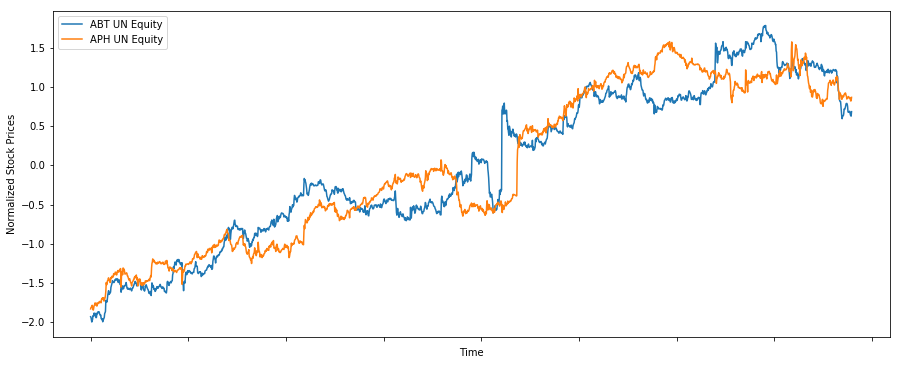

In [12]:
# =============================================
# show that a selected pair looks cointegrated
# =============================================
stock1='ABT UN Equity'
stock2='APH UN Equity'
# normalize the stock prices
series1=stocks[stock1].iloc[0:end_training]['Adj Close']
normalized_series1=(series1-series1.mean())/(series1.std())
series2=stocks[stock2].iloc[0:end_training]['Adj Close']
normalized_series2=(series2-series2.mean())/(series2.std())

# plot
plt.figure(figsize=(15,6))
plt.ylabel('Normalized Stock Prices')
normalized_series1.plot(label=stock1)
normalized_series2.plot(label=stock2)
plt.legend()
plt.show()

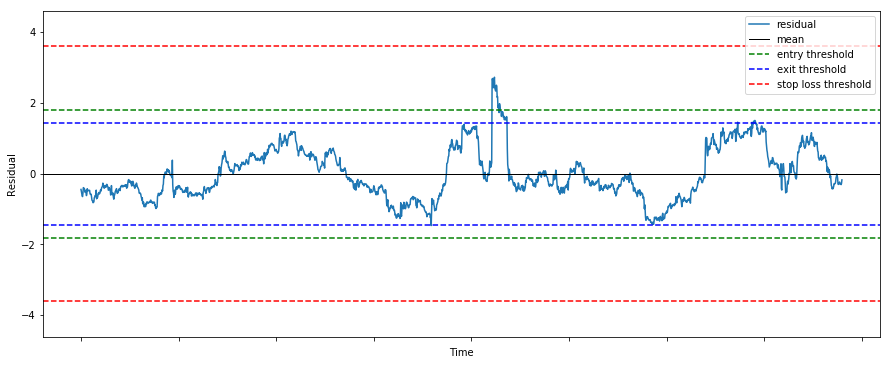

In [13]:
# =============================================
# plot the time series of the spread of a pair
# =============================================
t=0

std=store_selected_pair_info[t][(stock1,stock2)]['spreads'].std()
plt.figure(figsize=(15,6))
plt.ylabel('Residual')
temp_series=store_selected_pair_info[t][(stock1,stock2)]['spreads']-store_selected_pair_info[t][(stock1,stock2)]['mean']
temp_series.plot(label='residual')

plt.axhline(0, linewidth=1,color='black',label='mean') # Add the mean of residual
plt.axhline(std*entry_threshold, color='green', linestyle='--',label='entry threshold') 
plt.axhline(-std*entry_threshold, color='green', linestyle='--') 
plt.axhline(std*exit_threshold, color='blue', linestyle='--',label='exit threshold') 
plt.axhline(-std*exit_threshold, color='blue', linestyle='--') 
plt.axhline(std*stop_loss_threshold, color='red', linestyle='--',label='stop loss threshold') 
plt.axhline(-std*stop_loss_threshold, color='red', linestyle='--') 

plt.ylim(-std*stop_loss_threshold-1,std*stop_loss_threshold+1)
plt.legend()
plt.show()

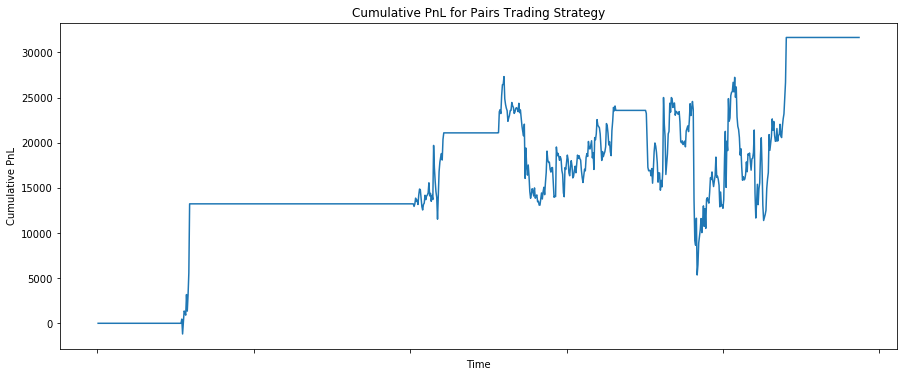

In [14]:
# ============================================
#   plot the Cumulative PnL of the portfolio
# ============================================
t=0

plt.figure(figsize=(15,6))
plt.ylabel('Cumulative PnL')
plt.title('Cumulative PnL for Pairs Trading Strategy')
dfpnl[t]['Cumulative PnL'].plot()
plt.show()

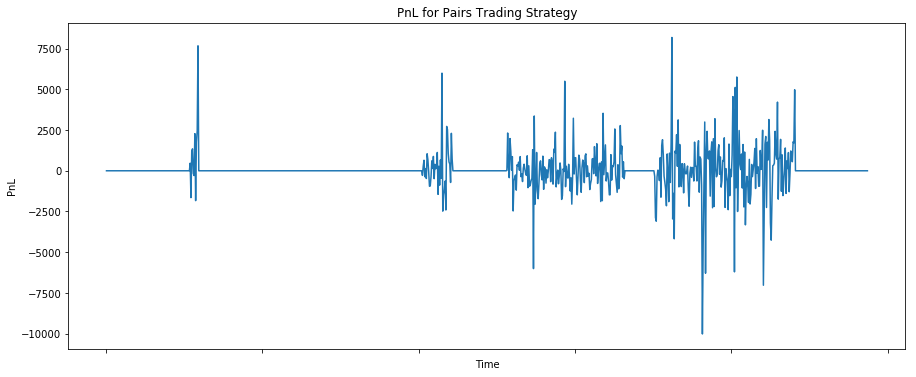

In [15]:
# =============================================
#         plot the PnL of the portfolio
# =============================================
t=0

plt.figure(figsize=(15,6))
plt.ylabel('PnL')
plt.title('PnL for Pairs Trading Strategy')
dfpnl[t]['PnL'].plot()
plt.show()

In [16]:
# =======================================================
# plot the heat map to optimize entry and exit thresholds
# =======================================================

import seaborn as sns
store_cum_pnl=[[22748.61,21497.14,25069.66,26382.61,24090.92],
               [23159.21,21872.84,24743.22,26217.71,24953.16],
               [22872.42,21077.28,25408.26,23844.72,24934.09],
               [23066.21,21623.94,24612.95,23223.83,25036.76],
               [23147.58,13229.65,21785.46,20460.00,25419.94],
               [18145.80,14758.37,22767.74,17909.68,20135.36],
               [5210.76,14195.56,19079.12,18172.47,15349.33]]

rows = [0.005,0.02,0.05,0.1,0.3,0.5,1]
columns =[1,1.5,2,2.5,3]
df=pd.DataFrame(store_cum_pnl,columns=columns,index=rows)
df

,1.0,1.5,2.0,2.5,3.0
0.005,22748.61,21497.14,25069.66,26382.61,24090.92
0.020,23159.21,21872.84,24743.22,26217.71,24953.16
0.050,22872.42,21077.28,25408.26,23844.72,24934.09
0.100,23066.21,21623.94,24612.95,23223.83,25036.76
0.300,23147.58,13229.65,21785.46,20460.00,25419.94
0.500,18145.80,14758.37,22767.74,17909.68,20135.36
1.000,5210.76,14195.56,19079.12,18172.47,15349.33


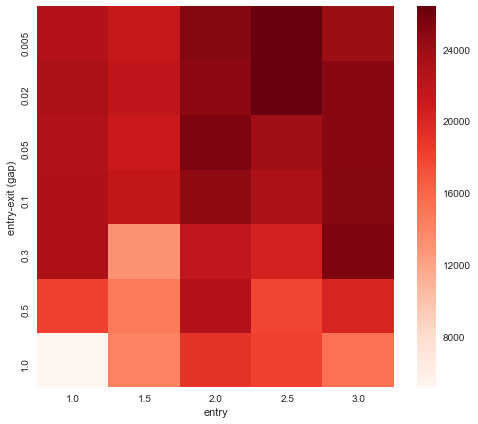

In [17]:
plt.figure(figsize=(8,7))
sns.heatmap(df,cmap=plt.cm.Reds)
plt.xlabel('entry')
plt.ylabel('entry-exit (gap)')

plt.show()
plt.close()